# Diabetes Prediction

Este notebook tem como objetivo construir e avaliar modelos de Machine Learning para prever diabetes,
utilizando o Pima Indians Diabetes Database. O foco é otimizar o Recall (sensibilidade) da classe
positiva (Diabéticos), que é uma métrica crucial em contextos de saúde para minimizar falsos negativos.

## Modificações Pré-Processamento

In [54]:
# Importação das Bbibliotecas:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from collections import Counter

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [ ]:
# Leitura do Dataset (PIMA Indians Diabetes (Kaggle)):

url = "https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv"
df = pd.read_csv(url)
df.head()

print("Dimensões do dataset:", df.shape)
df.head()

Dimensões do dataset: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
# Visão Inicial do Dataset:

print("Dimensões:", df.shape)
print("Colunas:", df.columns.tolist())
df.head()

Dimensões: (768, 9)
Colunas: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
# Tratamento de Dados:

# Remover espaços extras dos nomes das colunas:
df.columns = df.columns.str.strip()

# Verificar valores faltantes e estatísticas:
print("\nValores nulos:\n", df.isnull().sum())
print("\nResumo estatístico:\n", df.describe())

# As colunas abaixo não devem ter valores zero, pois indicam medidas biológicas.
# Substituímos 0 por NaN e depois imputamos com a mediana (o artigo usou a média,
# mas a mediana é mais robusta a outliers e uma boa prática).
columns_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for col in columns_with_zeros:
    df[col] = df[col].replace(0, np.nan) # Substitui 0 por NaN

# Imputar NaN com a mediana de cada coluna
for col in columns_with_zeros:
    median_val = df[col].median()
    df[col].fillna(median_val, inplace=True)

# Verificação final
print("\nValores ausentes após o tratamento:")
print(df.isnull().sum())


Valores nulos:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Resumo estatístico:
        Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.0000

## Análise Exploratória

In [ ]:
# Visão Geral do Dataset:

print("\nPrimeiras 5 linhas do DataFrame (após tratamento de zeros):\n\n")
print(df.head())

print("\nInformações sobre o DataFrame (tipos de dados, não-nulos):\n\n")
df.info()

print("\nEstatísticas Descritivas do DataFrame (após tratamento de zeros):\n\n")
print(df.describe())


Primeiras 5 linhas do DataFrame (após tratamento de zeros):


   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6    148.0           72.0           35.0    125.0  33.6   
1            1     85.0           66.0           29.0    125.0  26.6   
2            8    183.0           64.0           29.0    125.0  23.3   
3            1     89.0           66.0           23.0     94.0  28.1   
4            0    137.0           40.0           35.0    168.0  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Informações sobre o DataFrame (tipos de dados, não-nulos):


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------        


Contagem de valores para a variável 'Outcome':


Outcome
0    500
1    268
Name: count, dtype: int64
Proporção de 'Diabéticos' (1): 0.35
Proporção de 'Não Diabéticos' (0): 0.65


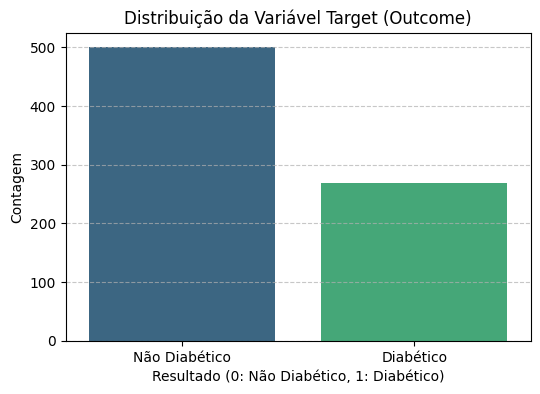

In [ ]:
# Análise da Variável Target (Outcome):

print("\nContagem de valores para a variável 'Outcome':\n\n")
print(df['Outcome'].value_counts())
print(f"Proporção de 'Diabéticos' (1): {df['Outcome'].value_counts(normalize=True)[1]:.2f}")
print(f"Proporção de 'Não Diabéticos' (0): {df['Outcome'].value_counts(normalize=True)[0]:.2f}")

plt.figure(figsize=(6, 4))
sns.countplot(x='Outcome', data=df, palette='viridis')
plt.title('Distribuição da Variável Target (Outcome)')
plt.xlabel('Resultado (0: Não Diabético, 1: Diabético)')
plt.ylabel('Contagem')
plt.xticks(ticks=[0, 1], labels=['Não Diabético', 'Diabético'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Visualizando a distribuição das features numéricas (Histogramas e Boxplots):




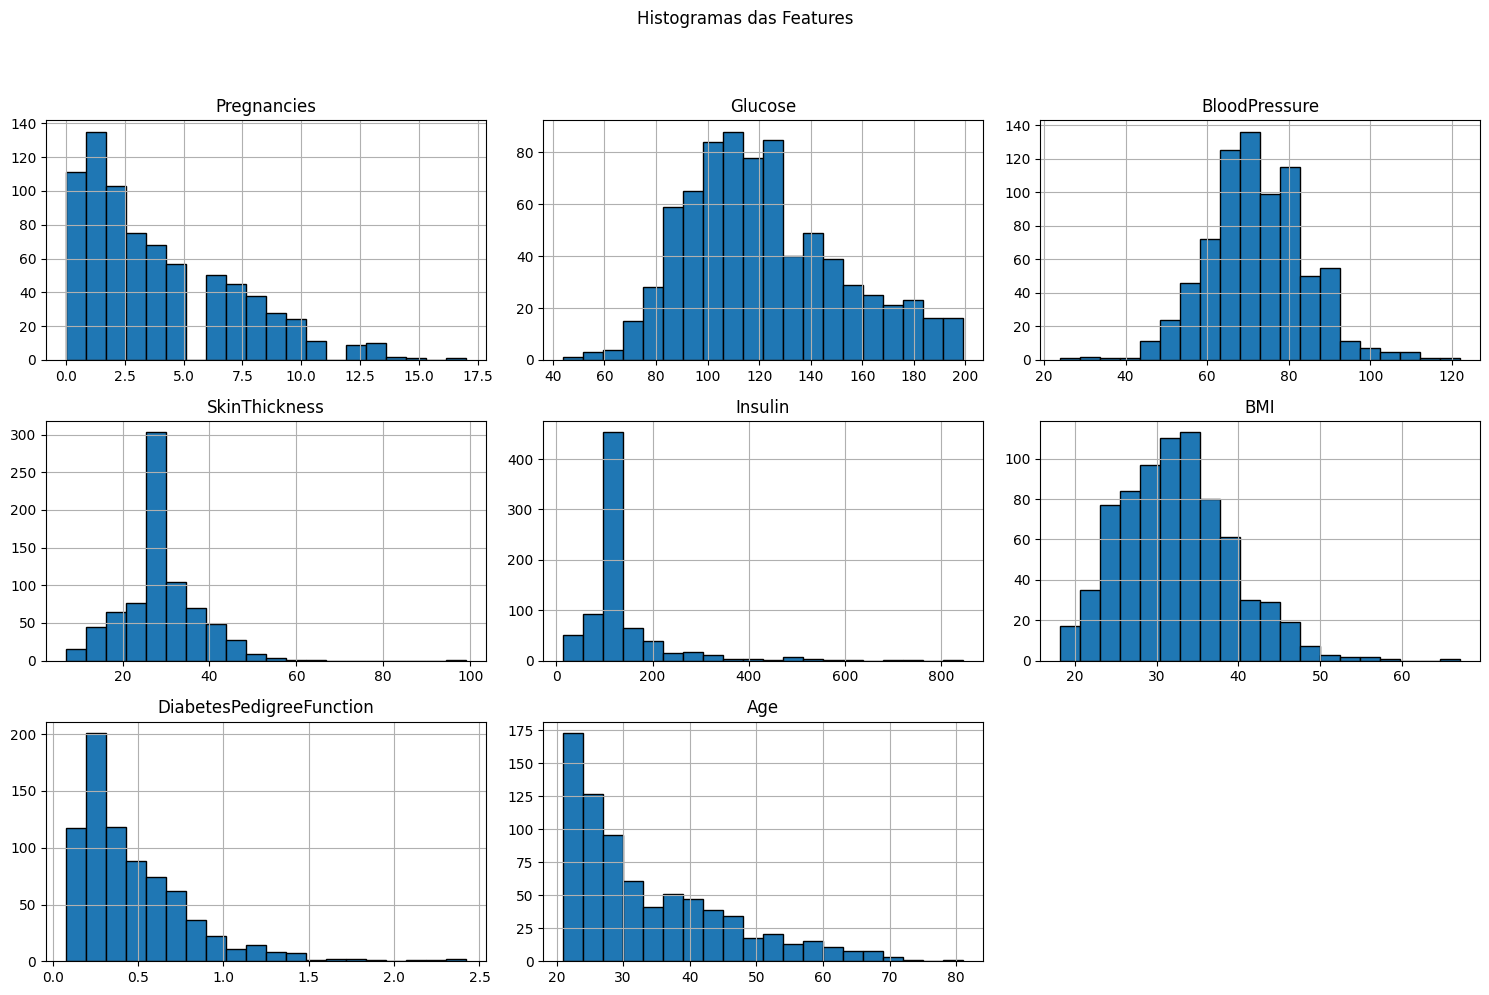

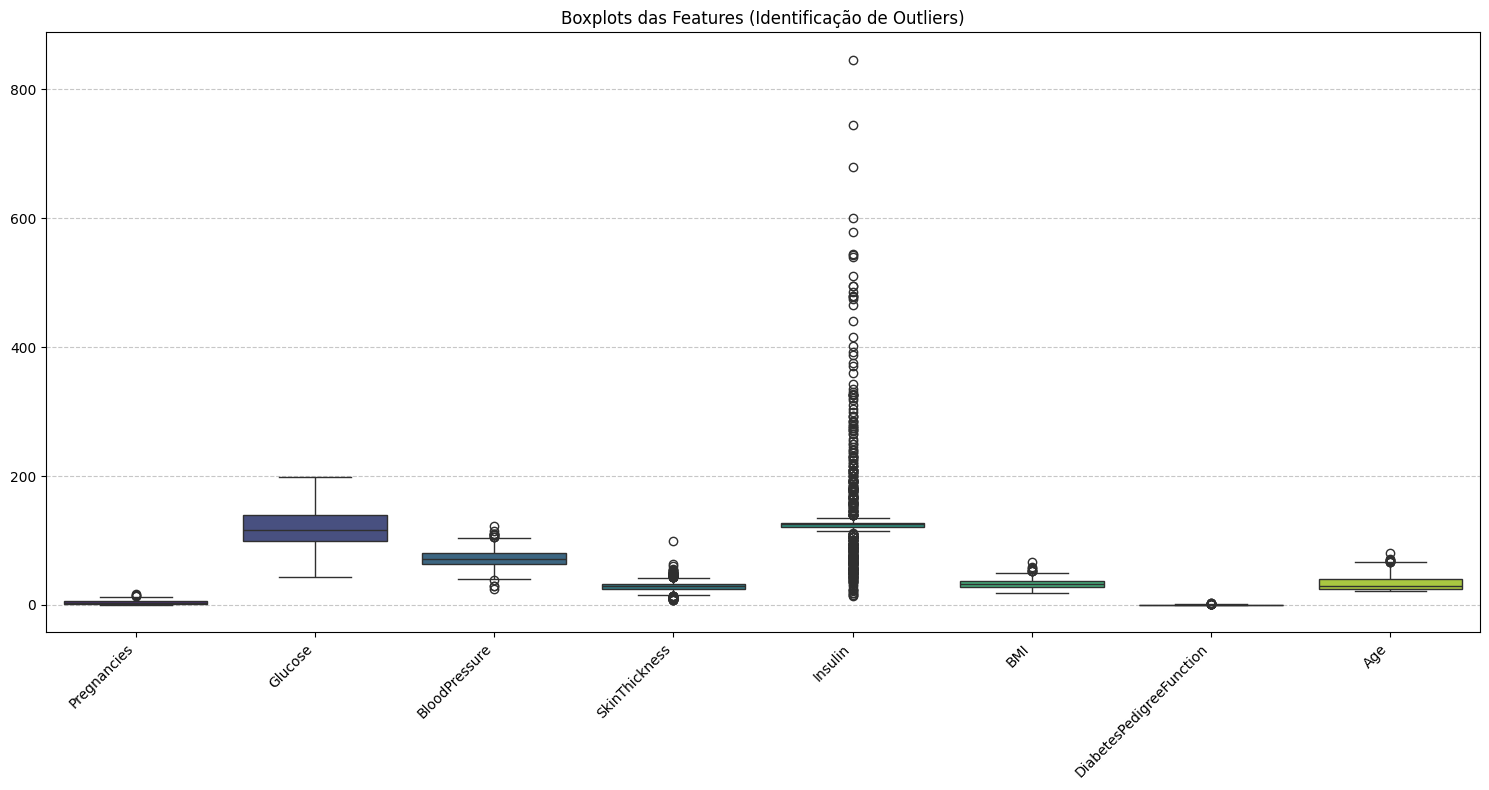

In [ ]:
# Distribuição das Features Numéricas:

print("\nVisualizando a distribuição das features numéricas (Histogramas e Boxplots):\n\n")

# Histograms:
df.iloc[:, :-1].hist(figsize=(15, 10), bins=20, edgecolor='black')
plt.suptitle('Histogramas das Features', y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Ajusta layout para evitar sobreposição de títulos
plt.show()

# Boxplots:
plt.figure(figsize=(15, 8))
sns.boxplot(data=df.iloc[:, :-1], palette='viridis')
plt.title('Boxplots das Features (Identificação de Outliers)')
plt.xticks(rotation=45, ha='right') # Rotaciona rótulos para melhor leitura
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Visualizando a Matriz de Correlação entre as Features e com a Target:




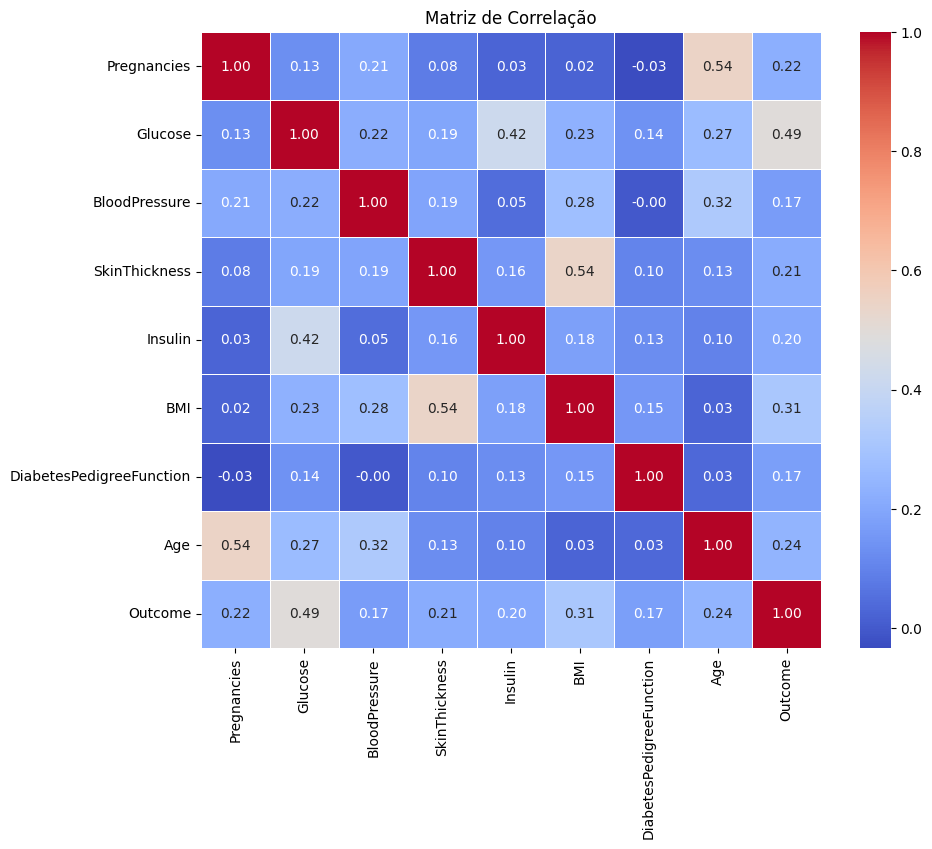


Features mais correlacionadas com o diagnóstico (Top 7):

Glucose                     0.492782
BMI                         0.312038
Age                         0.238356
Pregnancies                 0.221898
SkinThickness               0.214873
Insulin                     0.203790
DiabetesPedigreeFunction    0.173844
Name: Outcome, dtype: float64


In [ ]:
# Matriz de Correlação:

print("\nVisualizando a Matriz de Correlação entre as Features e com a Target:\n\n")
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação')
plt.show()

# Seleção de variáveis que tem maior correlação positiva (em valor absoluto):
top_features = df.corr()['Outcome'].abs().sort_values(ascending=False)[1:8]
print("\nFeatures mais correlacionadas com o diagnóstico (Top 7):\n")
print(top_features)

In [ ]:
# Teste t de comparação entre grupos (Outcome 0 vs Outcome 1):

print("\nTeste t de comparação entre grupos (Outcome 0 vs Outcome 1):\n\n")

features_for_ttest = df.columns.drop('Outcome')
for col in features_for_ttest:
    grupo0 = df[df['Outcome'] == 0][col]
    grupo1 = df[df['Outcome'] == 1][col]
    stat, p = ttest_ind(grupo0, grupo1, equal_var=False, nan_policy='omit')
    print(f"{col:25s} | p-valor = {p:.5f} {'(* Diferença significativa)' if p < 0.05 else ''}")
print("\n(*) p-valor < 0.05 indica uma diferença estatisticamente significativa na média da feature entre os dois grupos de Outcome.")


Teste t de comparação entre grupos (Outcome 0 vs Outcome 1):


Pregnancies               | p-valor = 0.00000 (* Diferença significativa)
Glucose                   | p-valor = 0.00000 (* Diferença significativa)
BloodPressure             | p-valor = 0.00000 (* Diferença significativa)
SkinThickness             | p-valor = 0.00000 (* Diferença significativa)
Insulin                   | p-valor = 0.00000 (* Diferença significativa)
BMI                       | p-valor = 0.00000 (* Diferença significativa)
DiabetesPedigreeFunction  | p-valor = 0.00001 (* Diferença significativa)
Age                       | p-valor = 0.00000 (* Diferença significativa)

(*) p-valor < 0.05 indica uma diferença estatisticamente significativa na média da feature entre os dois grupos de Outcome.



Visualizando Pair Plot das Features por Classe:




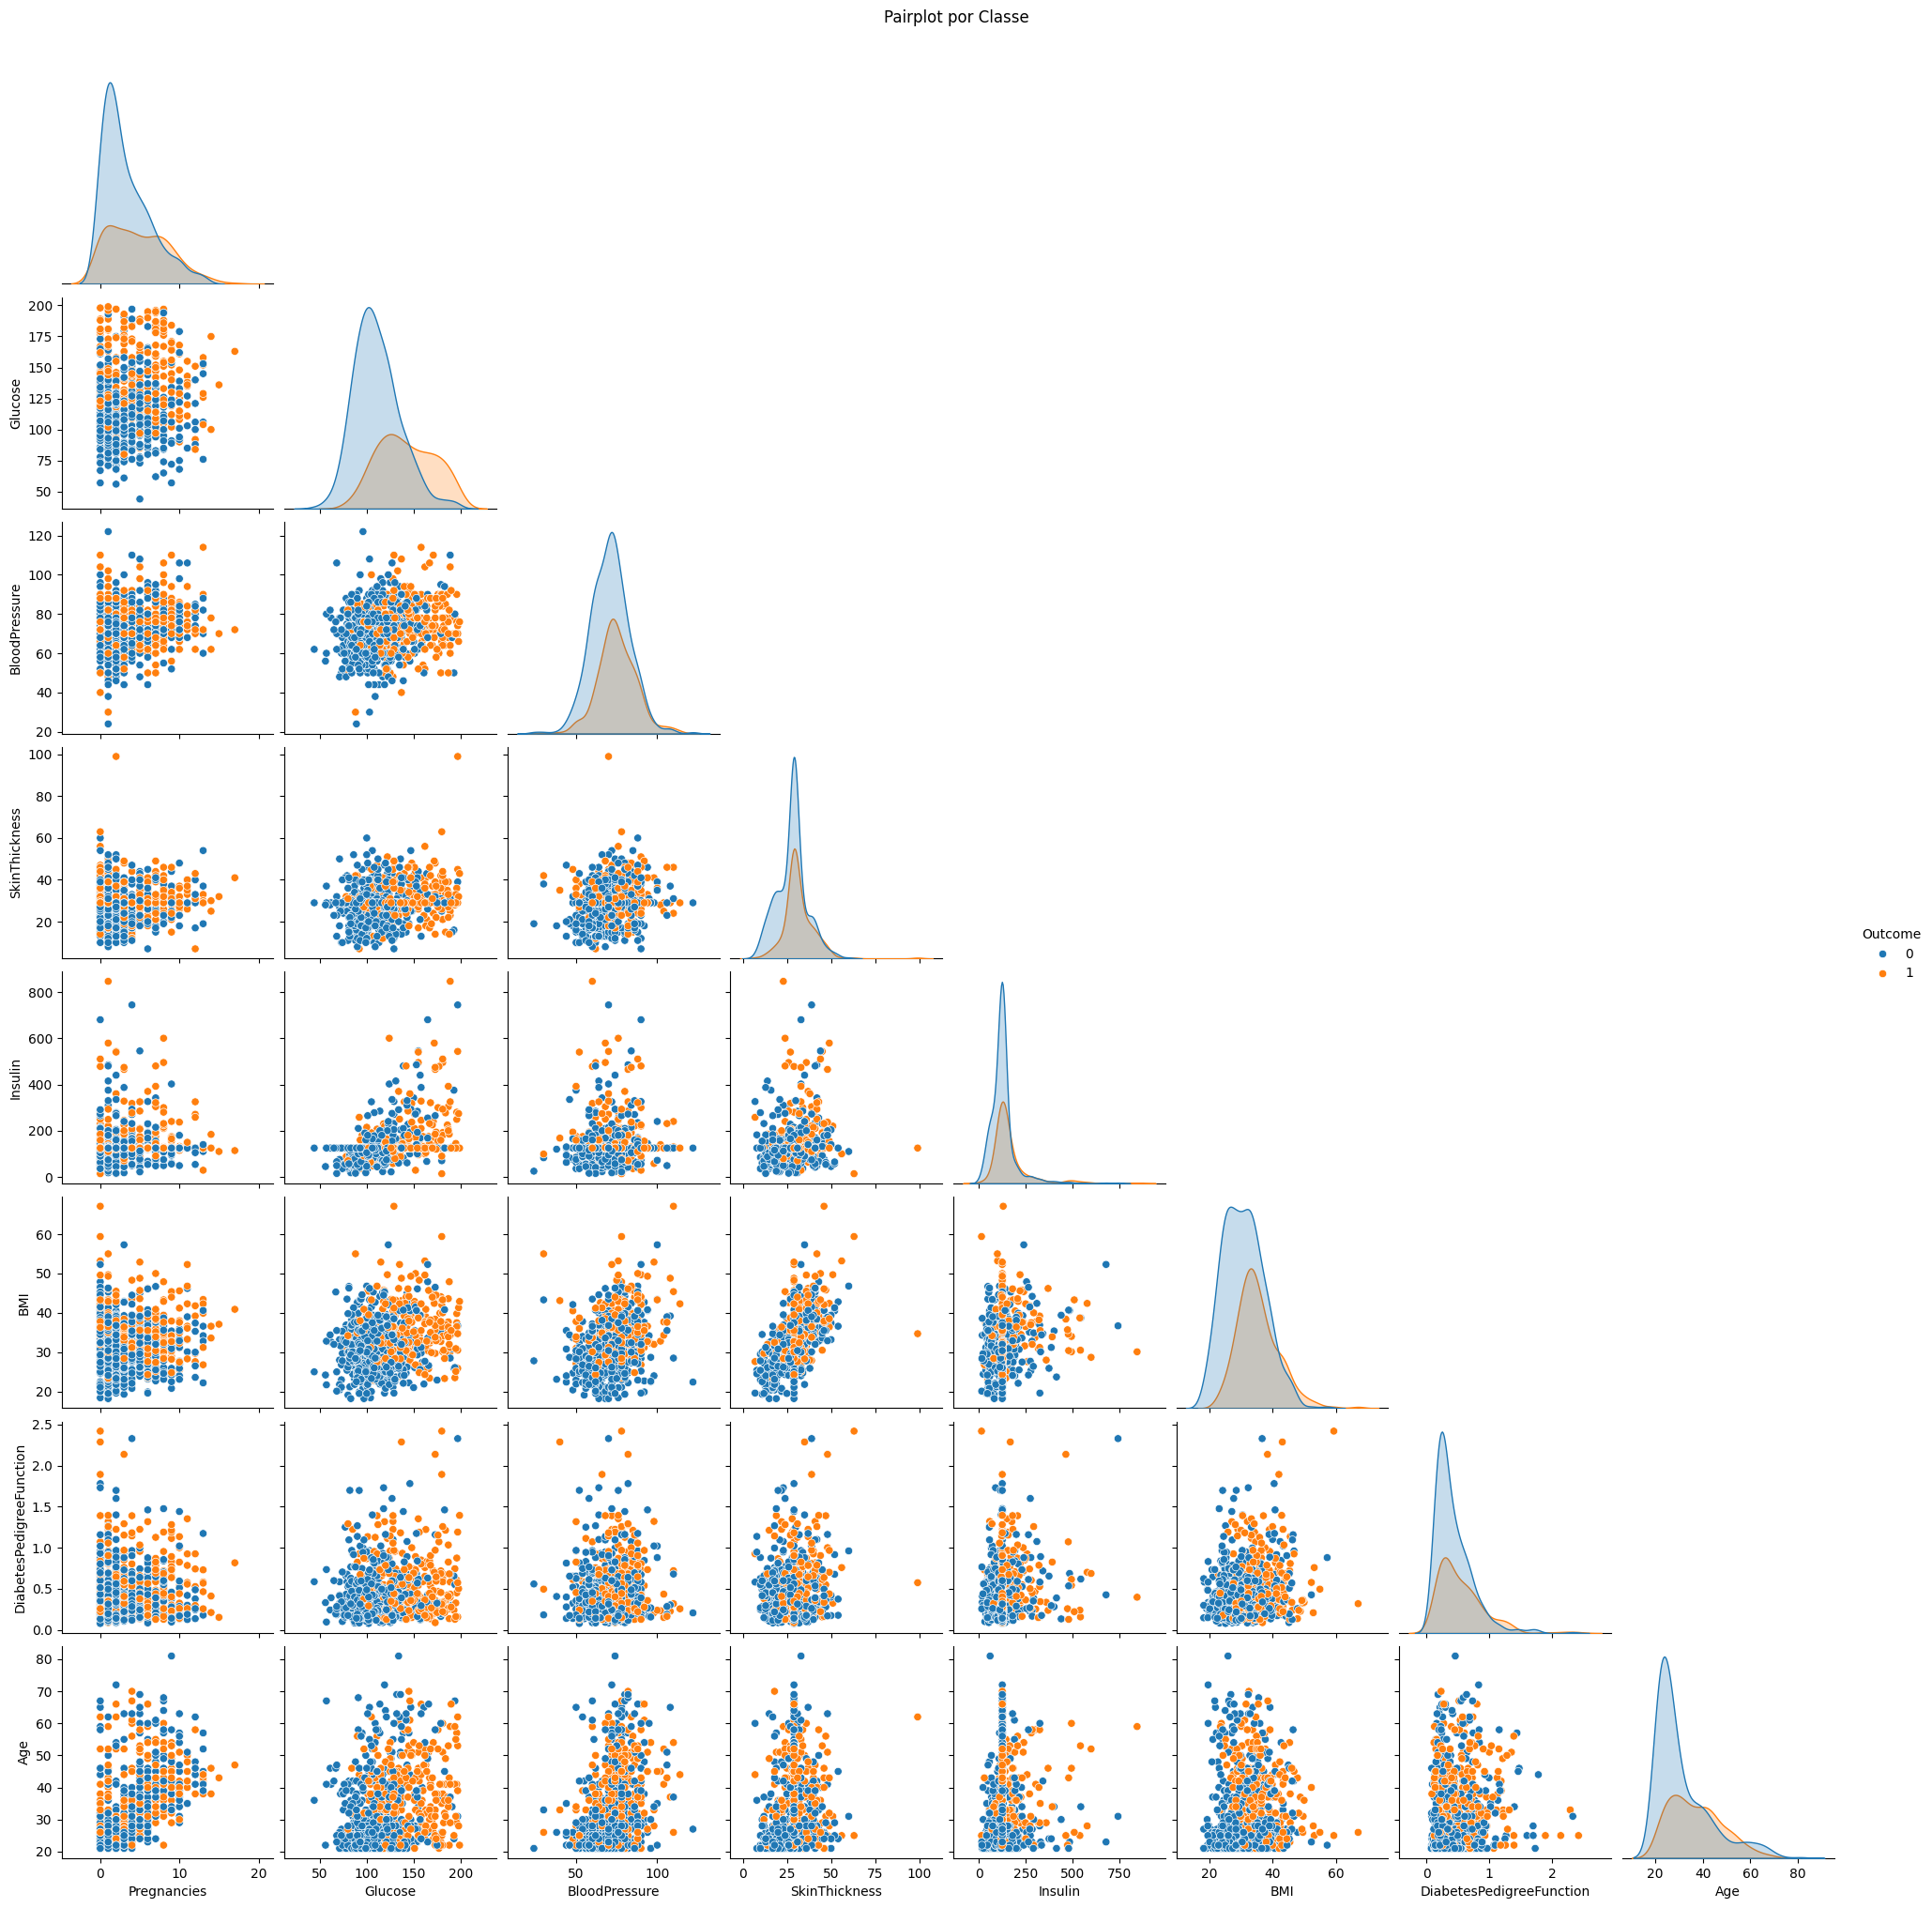

In [ ]:
# Pair Plot para a relação entre cada par de features e a distribuição da classe 'Outcome':

print("\nVisualizando Pair Plot das Features por Classe:\n\n")
features_for_pairplot = df.columns.drop('Outcome').tolist() # Lista de todas as features de entrada
sns.pairplot(df[features_for_pairplot + ['Outcome']], hue='Outcome', diag_kind='kde', corner=True)
plt.suptitle("Pairplot por Classe", y=1.02)
plt.show()

## Preparação dos Dados para Modelagem

In [ ]:
# Separando Features (X) e Target (y):

X = df.drop('Outcome', axis=1)
y = df['Outcome']
print(f"\nVariáveis independentes (X) shape: {X.shape}")
print(f"Variável dependente (y) shape: {y.shape}")


Variáveis independentes (X) shape: (768, 8)
Variável dependente (y) shape: (768,)


In [ ]:
# Divisão dos Dados em Treino e Teste (70/30 conforme o artigo):

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# O stratify=y garante que a proporção de classes (diabéticos/não diabéticos)
# seja mantida nos conjuntos de treino e teste.

print(f"\nDados divididos:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"Proporção de classes em y_train:\n{y_train.value_counts(normalize=True)}")
print(f"Proporção de classes em y_test:\n{y_test.value_counts(normalize=True)}")


Dados divididos:
X_train shape: (537, 8), y_train shape: (537,)
X_test shape: (231, 8), y_test shape: (231,)
Proporção de classes em y_train:
Outcome
0    0.651769
1    0.348231
Name: proportion, dtype: float64
Proporção de classes em y_test:
Outcome
0    0.649351
1    0.350649
Name: proportion, dtype: float64


In [ ]:
# Padronização dos Dados:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nDados de treino e teste padronizados.")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")


Dados de treino e teste padronizados.
X_train_scaled shape: (537, 8)
X_test_scaled shape: (231, 8)


## Treinamento e Avaliação dos Modelos

In [44]:
print("Cada modelo será otimizado usando GridSearchCV para encontrar os melhores hiperparâmetros,")
print("com foco na métrica 'recall' para a classe positiva (Diabéticos).")
print("-" * 80)

# Dicionário para armazenar os melhores modelos (após GridSearchCV):
best_models = {}
# Dicionário para armazenar o recall da classe 1 (Diabéticos) no conjunto de teste para comparação:
recall_scores = {}

# Logistic Regression:
print("\nLogistic Regression...")
param_grid_lr = [
    {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'class_weight': [None, 'balanced']},
    {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['lbfgs'], 'penalty': ['l2'], 'class_weight': [None, 'balanced']}
]
grid_lr = GridSearchCV(LogisticRegression(random_state=42, max_iter=200),
                        param_grid=param_grid_lr,
                        cv=5,          # 5-fold cross-validation
                        scoring='recall',     # Otimiza para Recall (classe 1 por padrão)
                        n_jobs=-1,            # Usa todos os núcleos da CPU disponíveis
                        verbose=1)            # Exibe o progresso

grid_lr.fit(X_train_scaled, y_train) # Treina no conjunto de treino PADRONIZADO

best_models['Logistic Regression'] = grid_lr.best_estimator_
y_pred_lr = best_models['Logistic Regression'].predict(X_test_scaled)
recall_scores['Logistic Regression'] = recall_score(y_test, y_pred_lr)

print(f"Melhores parâmetros LR: {grid_lr.best_params_}")
print(f"Melhor Recall (Validação Cruzada) LR: {grid_lr.best_score_:.4f}")
print(f"Recall (no conjunto de teste) LR: {recall_scores['Logistic Regression']:.4f}\n")
print("\nRelatório de Classificação para: Logistic Regression")
print(classification_report(y_test, y_pred_lr, target_names=['Não Diabético (0)', 'Diabético (1)']))
print("-" * 80)


# Support Vector Machine (SVM):
print("SVM...")
param_grid_svc = {
    'C': [0.1, 1, 10, 100],                       # Parâmetro de regularização.
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1], # Coeficiente do kernel.
    'kernel': ['rbf', 'linear'],                  # Tipo de kernel.
    'class_weight': [None, 'balanced']            # Para lidar com desbalanceamento.
}
grid_svc = GridSearchCV(SVC(random_state=42),
                         param_grid=param_grid_svc,
                         cv=5, scoring='recall', n_jobs=-1, verbose=1)

grid_svc.fit(X_train_scaled, y_train)

best_models['SVM'] = grid_svc.best_estimator_
y_pred_svc = best_models['SVM'].predict(X_test_scaled)
recall_scores['SVM'] = recall_score(y_test, y_pred_svc)

print(f"Melhores parâmetros SVM: {grid_svc.best_params_}")
print(f"Melhor Recall (Validação Cruzada) SVM: {grid_svc.best_score_:.4f}")
print(f"Recall (no conjunto de teste) SVM: {recall_scores['SVM']:.4f}\n")
print("\nRelatório de Classificação para: SVM")
print(classification_report(y_test, y_pred_svc, target_names=['Não Diabético (0)', 'Diabético (1)']))
print("-" * 80)


# K-Nearest Neighbors (KNN):
print("K-Nearest Neighbors...")
param_grid_knn = {
    'n_neighbors': list(range(1, 21, 2)) + [25, 30, 35, 40, 45, 50],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

print(f"   -> Distribuição original de y_train para KNN antes do SMOTE: {y_train.value_counts()}")
sm = SMOTE(random_state=42)
X_train_knn_resampled, y_train_knn_resampled = sm.fit_resample(X_train_scaled, y_train)
print(f"   -> Distribuição de y_train para KNN após o SMOTE: {y_train_knn_resampled.value_counts()}")

grid_knn = GridSearchCV(KNeighborsClassifier(),
                         param_grid=param_grid_knn,
                         cv=5,          # 5-fold cross-validation.
                         scoring='recall',     # Otimiza para Recall (classe 1 por padrão).
                         n_jobs=-1,            # Usa todos os núcleos da CPU disponíveis.
                         verbose=1)            # Exibe o progresso.

grid_knn.fit(X_train_knn_resampled, y_train_knn_resampled)

best_models['K-Nearest Neighbors'] = grid_knn.best_estimator_
y_pred_knn = best_models['K-Nearest Neighbors'].predict(X_test_scaled)
recall_scores['K-Nearest Neighbors'] = recall_score(y_test, y_pred_knn)

print(f"Melhores parâmetros KNN: {grid_knn.best_params_}")
print(f"Melhor Recall (Validação Cruzada - com SMOTE) KNN: {grid_knn.best_score_:.4f}")
print(f"Recall (no conjunto de teste) KNN: {recall_scores['K-Nearest Neighbors']:.4f}\n")
print("\nRelatório de Classificação para: K-Nearest Neighbors")
print(classification_report(y_test, y_pred_knn, target_names=['Não Diabético (0)', 'Diabético (1)']))
print("-" * 80)


# Gaussian Naive Bayes:
print("Gaussian Naive Bayes...")
param_grid_gnb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

print(f"   -> Distribuição original de y_train para GNB antes do SMOTE: {y_train.value_counts()}")
sm_gnb = SMOTE(random_state=42)
X_train_gnb_resampled, y_train_gnb_resampled = sm_gnb.fit_resample(X_train_scaled, y_train)
print(f"   -> Distribuição de y_train para GNB após o SMOTE: {y_train_gnb_resampled.value_counts()}")

print("   -> Aplicando PowerTransformer (Yeo-Johnson) para GNB...")
pt_gnb = PowerTransformer(method='yeo-johnson', standardize=True)

X_train_gnb_transformed = pt_gnb.fit_transform(X_train_gnb_resampled)
X_test_gnb_transformed = pt_gnb.transform(X_test_scaled)

grid_gnb = GridSearchCV(GaussianNB(),
                         param_grid=param_grid_gnb,
                         cv=5,
                         scoring='recall',
                         n_jobs=-1,
                         verbose=1)

grid_gnb.fit(X_train_gnb_transformed, y_train_gnb_resampled)

best_models['Gaussian Naive Bayes'] = grid_gnb.best_estimator_
y_pred_gnb = best_models['Gaussian Naive Bayes'].predict(X_test_gnb_transformed)
recall_scores['Gaussian Naive Bayes'] = recall_score(y_test, y_pred_gnb)

print(f"Melhores parâmetros GNB: {grid_gnb.best_params_}")
print(f"Melhor Recall (Validação Cruzada - com SMOTE & Transformação) GNB: {grid_gnb.best_score_:.4f}")
print(f"Recall (no conjunto de teste) GNB: {recall_scores['Gaussian Naive Bayes']:.4f}\n")
print("\nRelatório de Classificação para: Gaussian Naive Bayes")
print(classification_report(y_test, y_pred_gnb, target_names=['Não Diabético (0)', 'Diabético (1)']))
print("-" * 80)


# Decision Tree Classifier:
print("Decision Tree...")
param_grid_dt = {
    'max_depth': [None, 5, 10, 20, 30],         # Profundidade máxima da árvore.
    'min_samples_split': [2, 5, 10],            # Mínimo de amostras para dividir um nó.
    'min_samples_leaf': [1, 2, 4],              # Mínimo de amostras em um nó folha.
    'criterion': ['gini', 'entropy'],           # Medida da qualidade de um split.
    'class_weight': [None, 'balanced']          # Para lidar com desbalanceamento.
}
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42),
                        param_grid=param_grid_dt,
                        cv=5, scoring='recall', n_jobs=-1, verbose=1)

grid_dt.fit(X_train_scaled, y_train)

best_models['Decision Tree'] = grid_dt.best_estimator_
y_pred_dt = best_models['Decision Tree'].predict(X_test_scaled)
recall_scores['Decision Tree'] = recall_score(y_test, y_pred_dt)

print(f"Melhores parâmetros DT: {grid_dt.best_params_}")
print(f"Melhor Recall (Validação Cruzada) DT: {grid_dt.best_score_:.4f}")
print(f"Recall (no conjunto de teste) DT: {recall_scores['Decision Tree']:.4f}\n")
print("\nRelatório de Classificação para: Decision Tree")
print(classification_report(y_test, y_pred_dt, target_names=['Não Diabético (0)', 'Diabético (1)']))
print("-" * 80)


# Random Forest Classifier:
print("Random Forest...")
param_grid_rf = {
    'n_estimators': [100, 200, 300, 500, 800, 1000, 1200, 1500],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [None, 5, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'class_weight': [None, 'balanced']
}

random_search_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                                      param_distributions=param_grid_rf,
                                      n_iter=100,
                                      cv=5,
                                      scoring='recall',
                                      n_jobs=-1,
                                      verbose=1,
                                      random_state=42)

random_search_rf.fit(X_train_scaled, y_train)

best_models['Random Forest'] = random_search_rf.best_estimator_
y_pred_rf = best_models['Random Forest'].predict(X_test_scaled)
recall_scores['Random Forest'] = recall_score(y_test, y_pred_rf)

print(f"Melhores parâmetros RF: {random_search_rf.best_params_}")
print(f"Melhor Recall (Validação Cruzada) RF: {random_search_rf.best_score_:.4f}")
print(f"Recall (no conjunto de teste) RF: {recall_scores['Random Forest']:.4f}\n")
print("\nRelatório de Classificação para: Random Forest")
print(classification_report(y_test, y_pred_rf, target_names=['Não Diabético (0)', 'Diabético (1)']))
print("-" * 80)

Cada modelo será otimizado usando GridSearchCV para encontrar os melhores hiperparâmetros,
com foco na métrica 'recall' para a classe positiva (Diabéticos).
--------------------------------------------------------------------------------

Logistic Regression...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Melhores parâmetros LR: {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Melhor Recall (Validação Cruzada) LR: 0.7533
Recall (no conjunto de teste) LR: 0.7901


Relatório de Classificação para: Logistic Regression
                   precision    recall  f1-score   support

Não Diabético (0)       0.86      0.71      0.78       150
    Diabético (1)       0.60      0.79      0.68        81

         accuracy                           0.74       231
        macro avg       0.73      0.75      0.73       231
     weighted avg       0.77      0.74      0.75       231

-------------------------------------------------------------------------

In [61]:
# Treinamento e Otimização de Modelos com GridSearchCV

print("Cada modelo será otimizado usando GridSearchCV para encontrar os melhores hiperparâmetros,")
print("com foco na métrica 'recall' para a classe positiva (Diabéticos).")
print("-" * 80)

# Dicionário para armazenar os melhores modelos (após GridSearchCV):
best_models = {}
# Dicionário para armazenar o recall da classe 1 (Diabéticos) no conjunto de teste para comparação:
recall_scores = {}

# Logistic Regression:
print("\nLogistic Regression...")
param_grid_lr = [
    {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'class_weight': [None, 'balanced']},
    {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['lbfgs'], 'penalty': ['l2'], 'class_weight': [None, 'balanced']}
]
grid_lr = GridSearchCV(LogisticRegression(random_state=42, max_iter=200),
                       param_grid=param_grid_lr,
                       cv=5,                 # 5-fold cross-validation
                       scoring='recall',     # Otimiza para Recall (classe 1 por padrão)
                       n_jobs=-1,            # Usa todos os núcleos da CPU disponíveis
                       verbose=1)            # Exibe o progresso

grid_lr.fit(X_train_scaled, y_train) # Treina no conjunto de treino PADRONIZADO

best_models['Logistic Regression'] = grid_lr.best_estimator_
y_pred_lr = best_models['Logistic Regression'].predict(X_test_scaled)
recall_scores['Logistic Regression'] = recall_score(y_test, y_pred_lr)

print(f"\n{'='*30} Logistic Regression {'='*30}")
print(f"↪ Melhores parâmetros: {grid_lr.best_params_}")
print(f"↪ Melhor Recall (Validação Cruzada): {grid_lr.best_score_:.4f}")
print(f"↪ Recall (Conjunto de Teste): {recall_scores['Logistic Regression']:.4f}")
print("-" * 80)

# Support Vector Machine (SVM):
print("SVM...")
param_grid_svc = {
    'C': [0.1, 1, 10, 100],                         # Parâmetro de regularização.
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1], # Coeficiente do kernel.
    'kernel': ['rbf', 'linear'],                    # Tipo de kernel.
    'class_weight': [None, 'balanced']              # Para lidar com desbalanceamento.
}
grid_svc = GridSearchCV(SVC(random_state=42),
                        param_grid=param_grid_svc,
                        cv=5, scoring='recall', n_jobs=-1, verbose=1)

grid_svc.fit(X_train_scaled, y_train)

best_models['SVM'] = grid_svc.best_estimator_
y_pred_svc = best_models['SVM'].predict(X_test_scaled)
recall_scores['SVM'] = recall_score(y_test, y_pred_svc)

print(f"\n{'='*30} Support Vector Machine (SVM) {'='*30}")
print(f"↪ Melhores parâmetros: {grid_svc.best_params_}")
print(f"↪ Melhor Recall (Validação Cruzada): {grid_svc.best_score_:.4f}")
print(f"↪ Recall (Conjunto de Teste): {recall_scores['SVM']:.4f}")
print("-" * 80)


# K-Nearest Neighbors (KNN):
print("K-Nearest Neighbors...")
param_grid_knn = {
    'n_neighbors': list(range(1, 21, 2)) + [25, 30, 35, 40, 45, 50],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

from imblearn.over_sampling import SMOTE
print(f"  -> Distribuição original de y_train para KNN antes do SMOTE: {y_train.value_counts()}")
sm = SMOTE(random_state=42)
X_train_knn_resampled, y_train_knn_resampled = sm.fit_resample(X_train_scaled, y_train)
print(f"  -> Distribuição de y_train para KNN após o SMOTE: {y_train_knn_resampled.value_counts()}")

grid_knn = GridSearchCV(KNeighborsClassifier(),
                        param_grid=param_grid_knn,
                        cv=5,                 # 5-fold cross-validation.
                        scoring='recall',     # Otimiza para Recall (classe 1 por padrão).
                        n_jobs=-1,            # Usa todos os núcleos da CPU disponíveis.
                        verbose=1)            # Exibe o progresso.

grid_knn.fit(X_train_knn_resampled, y_train_knn_resampled)

best_models['K-Nearest Neighbors'] = grid_knn.best_estimator_
y_pred_knn = best_models['K-Nearest Neighbors'].predict(X_test_scaled)
recall_scores['K-Nearest Neighbors'] = recall_score(y_test, y_pred_knn)

print(f"\n{'='*30} K-Nearest Neighbors {'='*30}")
print(f"↪ Melhores parâmetros: {grid_knn.best_params_}")
print(f"↪ Melhor Recall (Validação Cruzada com SMOTE): {grid_knn.best_score_:.4f}")
print(f"↪ Recall (Conjunto de Teste): {recall_scores['K-Nearest Neighbors']:.4f}")
print("-" * 80)


# Gaussian Naive Bayes:
print("Gaussian Naive Bayes...")
param_grid_gnb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

print(f"  -> Distribuição original de y_train para GNB antes do SMOTE: {y_train.value_counts()}")
sm_gnb = SMOTE(random_state=42)
X_train_gnb_resampled, y_train_gnb_resampled = sm_gnb.fit_resample(X_train_scaled, y_train)
print(f"  -> Distribuição de y_train para GNB após o SMOTE: {y_train_gnb_resampled.value_counts()}")

from sklearn.preprocessing import PowerTransformer
print("  -> Aplicando PowerTransformer (Yeo-Johnson) para GNB...")
pt_gnb = PowerTransformer(method='yeo-johnson', standardize=True)

X_train_gnb_transformed = pt_gnb.fit_transform(X_train_gnb_resampled)
X_test_gnb_transformed = pt_gnb.transform(X_test_scaled)

grid_gnb = GridSearchCV(GaussianNB(),
                        param_grid=param_grid_gnb,
                        cv=5,
                        scoring='recall',
                        n_jobs=-1,
                        verbose=1)

grid_gnb.fit(X_train_gnb_transformed, y_train_gnb_resampled)

best_models['Gaussian Naive Bayes'] = grid_gnb.best_estimator_
y_pred_gnb = best_models['Gaussian Naive Bayes'].predict(X_test_gnb_transformed)
recall_scores['Gaussian Naive Bayes'] = recall_score(y_test, y_pred_gnb)

print(f"\n{'='*30} Gaussian Naive Bayes {'='*30}")
print(f"↪ Melhores parâmetros: {grid_gnb.best_params_}")
print(f"↪ Melhor Recall (Validação Cruzada com SMOTE & PowerTransformer): {grid_gnb.best_score_:.4f}")
print(f"↪ Recall (Conjunto de Teste): {recall_scores['Gaussian Naive Bayes']:.4f}")
print("-" * 80)


# Decision Tree Classifier:
print("Decision Tree...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
print(f"Distribuição após SMOTE: {Counter(y_train_smote)}\n")

param_grid_dt = {
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced']
}

print("Otimizando com GridSearchCV...")
grid_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=param_grid_dt,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

grid_dt.fit(X_train_smote, y_train_smote)
best_model_dt = grid_dt.best_estimator_

# Armazena no dicionário se estiver usando!
best_models['Decision Tree'] = best_model_dt

print("Testando thresholds para maximizar o Recall...")
y_proba = best_model_dt.predict_proba(X_test_scaled)[:, 1]

thresholds = np.arange(0.1, 0.6, 0.05)
best_threshold = 0.5
best_recall = 0
results = []

for t in thresholds:
    y_pred_thresh = (y_proba >= t).astype(int)
    r = recall_score(y_test, y_pred_thresh)
    p = precision_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    results.append((t, r, p, f1))
    if r > best_recall:
        best_recall = r
        best_threshold = t

y_pred_final = (y_proba >= best_threshold).astype(int)
recall_scores['Decision Tree'] = recall_score(y_test, y_pred_final)

print(f"\n{'='*30} Decision Tree {'='*30}")
print(f"↪ Melhores parâmetros: {grid_dt.best_params_}")
print(f"↪ Melhor Recall (Validação Cruzada): {grid_dt.best_score_:.4f}")
print(f"↪ Melhor Threshold encontrado: {best_threshold:.2f}")
print(f"↪ Recall (Conjunto de Teste com Threshold Ajustado): {recall_scores['Decision Tree']:.4f}")
print("-" * 80)

# Random Forest Classifier:
print("Random Forest...")

pipeline_rf_smote = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid_rf_smote = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_features': ['sqrt'],
    'classifier__max_depth': [10, 20, 30],
    'classifier__min_samples_split': [5, 10],
    'classifier__min_samples_leaf': [2, 4],
    'classifier__class_weight': ['balanced'],
    'smote__k_neighbors': [5, 7]
}

n_iterations = 20
random_search_rf_smote = RandomizedSearchCV(
    pipeline_rf_smote,
    param_distributions=param_grid_rf_smote,
    n_iter=n_iterations,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search_rf_smote.fit(X_train_scaled, y_train)
best_rf_model = random_search_rf_smote.best_estimator_
best_models['Random Forest com SMOTE'] = best_rf_model

y_proba_rf = best_models['Random Forest com SMOTE'].predict_proba(X_test_scaled)[:, 1]

threshold = 0.35
y_pred_rf_threshold = (y_proba_rf >= threshold).astype(int)

recall_scores['Random Forest com SMOTE'] = recall_score(y_test, y_pred_rf_threshold)

print(f"\n{'='*30} Random Forest com SMOTE {'='*30}")
print(f"↪ Melhores parâmetros: {random_search_rf_smote.best_params_}")
print(f"↪ Melhor Recall (Validação Cruzada): {random_search_rf_smote.best_score_:.4f}")
print(f"↪ Threshold utilizado no Teste: {threshold:.2f}")
print(f"↪ Recall (Conjunto de Teste com Threshold Ajustado): {recall_scores['Random Forest com SMOTE']:.4f}")
print(f"↪ Precision: {precision_score(y_test, y_pred_rf_threshold):.4f}")
print(f"↪ F1-score: {f1_score(y_test, y_pred_rf_threshold):.4f}")
print("-" * 80)

Cada modelo será otimizado usando GridSearchCV para encontrar os melhores hiperparâmetros,
com foco na métrica 'recall' para a classe positiva (Diabéticos).
--------------------------------------------------------------------------------

Logistic Regression...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

============================== Logistic Regression ==============================
↪ Melhores parâmetros: {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
↪ Melhor Recall (Validação Cruzada): 0.7533
↪ Recall (Conjunto de Teste): 0.7901
--------------------------------------------------------------------------------
SVM...
Fitting 5 folds for each of 96 candidates, totalling 480 fits

============================== Support Vector Machine (SVM) ==============================
↪ Melhores parâmetros: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}
↪ Melhor Recall (Validação Cruzada): 0.7908
↪ Recall (Conjunto de Tes

Análise detalhada do desempenho de cada modelo otimizado no conjunto de teste.
--------------------------------------------------------------------------------

Relatório de Classificação para: Logistic Regression
                   precision    recall  f1-score   support

Não Diabético (0)       0.86      0.71      0.78       150
    Diabético (1)       0.60      0.79      0.68        81

         accuracy                           0.74       231
        macro avg       0.73      0.75      0.73       231
     weighted avg       0.77      0.74      0.75       231

-------------------------------------------------

Relatório de Classificação para: SVM
                   precision    recall  f1-score   support

Não Diabético (0)       0.84      0.69      0.76       150
    Diabético (1)       0.57      0.77      0.65        81

         accuracy                           0.71       231
        macro avg       0.71      0.73      0.70       231
     weighted avg       0.75      0.71      

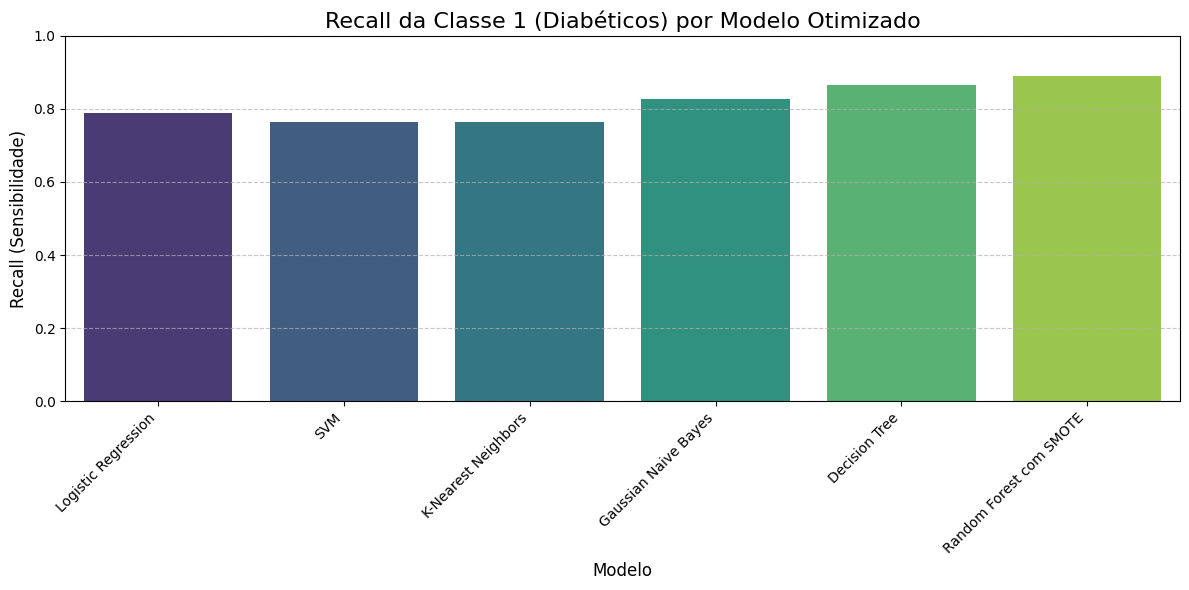

In [62]:
# Avaliação e Comparação Final dos Modelos Otimizados

print("Análise detalhada do desempenho de cada modelo otimizado no conjunto de teste.")
print("-" * 80)

# Gerar e imprimir o Classification Report para cada modelo:
for name, model in best_models.items():
    y_pred = model.predict(X_test_scaled)
    print(f"\nRelatório de Classificação para: {name}")
    print(classification_report(y_test, y_pred, target_names=['Não Diabético (0)', 'Diabético (1)']))
    print("-" * (len(name) + 30))

# Comparar os Recall da Classe 1 (Diabéticos) de todos os modelos:
print("\nComparação de Recall da Classe 1 (Diabéticos) no Conjunto de Teste...")
for name, score in sorted(recall_scores.items(), key=lambda item: item[1], reverse=True):
    print(f"{name.ljust(25)} | Recall Classe 1 (Diabéticos): {score:.4f}")

# Visualização do Recall da Classe 1:
model_names = list(recall_scores.keys())
recall_values = list(recall_scores.values())

plt.figure(figsize=(12, 6))
sns.barplot(x=model_names, y=recall_values, palette='viridis')
plt.title('Recall da Classe 1 (Diabéticos) por Modelo Otimizado', fontsize=16)
plt.ylabel('Recall (Sensibilidade)', fontsize=12)
plt.xlabel('Modelo', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()